In [34]:
import math
from matplotlib.pyplot import *
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy

# Codes de triangulations

In [35]:
def trianguler_polygone(polygone):
    '''regroupe tout'''
    
    def equation_droite(P0,P1,M):
        '''produit vectoriel projeté'''
        return (P1[0]-P0[0])*(M[1]-P0[1])-(P1[1]-P0[1])*(M[0]-P0[0])


    def point_dans_triangle(triangle,M):
        '''explicite'''
        P0 = triangle[0]
        P1 = triangle[1]
        P2 = triangle[2]

        aucun_neg = equation_droite(P0,P1,M) >= 0 and equation_droite(P1,P2,M) >= 0 and equation_droite(P2,P0,M) >= 0
        aucun_pos = equation_droite(P0,P1,M) <= 0 and equation_droite(P1,P2,M) <= 0 and equation_droite(P2,P0,M) <= 0
        return aucun_neg or aucun_pos


    def sommet_coupe(polygone,P0,P1,P2,indices):
        '''cas où il y a des sommets dans le triangle et qu'il faut decouper en deux'''
        n = len(polygone)
        distance = 0.0
        j = None
        for i in range(n):
            if not(i in indices) and point_dans_triangle([P0,P1,P2],polygone[i]): 
                M = polygone[i]
                d = abs(equation_droite(P1,P2,M))
                if distance == 0 and d ==0:
                    '''si est sur la bordure du triangle'''
                    j = i
                if d > distance:
                    distance = d
                    j = i           
        return j

    def sommet_gauche(polygone):
        '''sommet le plus à gauche'''
        n = len(polygone)
        x = polygone[0][0]
        j = 0
        for i in range(1,n):
            if polygone[i][0] < x:
                x = polygone[i][0]
                j = i
        return j
    
    def voisin_sommet(n,i,di):
        '''sommet voisin preserve cyclicité'''
        return (i+di)%n

    def nouveau_polygone(polygone,i_debut,i_fin):
        '''explicite'''
        n = len(polygone)
        p = []
        i = i_debut
        while i!=i_fin:
            p.append(polygone[i])
            i = voisin_sommet(n,i,1)
        p.append(polygone[i_fin])
        return p 

    def trianguler(polygone,liste_triangles):
        '''triangule le polygone par recurrence'''
        # à réécrire pour optimiser
        n = len(polygone)
        if n == 3:
            liste_triangles.append(polygone)
            
        if n >3:
            j0 = sommet_gauche(polygone)
            j1 = voisin_sommet(n,j0,1)
            j2 = voisin_sommet(n,j0,-1)

            A = polygone[j0]
            B = polygone[j1]
            C = polygone[j2]

            j = sommet_coupe(polygone,A,B,C,[j0,j1,j2])
            '''2 cas si diagonale dans polygone ou non '''
            if j==None:
                liste_triangles.append([A,B,C])
                trianguler(nouveau_polygone(polygone,j1,j2),liste_triangles)
            else:
                trianguler(nouveau_polygone(polygone,j0,j),liste_triangles)
                trianguler(nouveau_polygone(polygone,j,j0),liste_triangles)   
        
    liste_triangles = []
    trianguler(polygone,liste_triangles)
    return liste_triangles
                    
def draw_liste_triangles(liste_triangles):
    fig,ax = subplots()
    patches = []
    for triangle in liste_triangles:
        patches.append(Polygon(triangle))
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=1.0)
    colors = 100*numpy.random.rand(len(patches))
    p.set_array(numpy.array(colors))
    ax.add_collection(p)


# Codes de coloration

In [36]:

def couleur_va(graph,sommet,liste_couleur,couleur):
    """ check si le sommet peut accepter cette couleur """
    for i in range(len(graph)):
        if graph[sommet][i]==1 and liste_couleur[i]==couleur:
            return False
    return True

def coloration_rec_3(graph,liste_couleur,sommet):
    """ coloration recursive """
    
    if sommet==len(graph):
        return True
    
    for couleur in range(1,4):
        if couleur_va(graph,sommet,liste_couleur,couleur):
            liste_couleur[sommet] = couleur
            if coloration_rec_3(graph,liste_couleur,sommet+1):
                return True
            liste_couleur[sommet] = 0
            
def tricolore(graph):
    """renvoie liste des sommet colorés"""
    liste_couleur = [0 for i in range(len(graph))]
    if not coloration_rec_3(graph,liste_couleur,0):
        return False
    return liste_couleur

graph = [[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]]
tricolore(graph)
                
def polygone_vers_graph(polygone):
    dic_sommets = {}
    n = 0
    for sommet in polygone:
        dic_sommets[sommet] = n
        n+=1
        
    matrice_adjacence = [[0 for j in range(len(polygone))] for i in range(len(polygone))]
    triangles = trianguler_polygone(polygone)
    
    for x,y,z in triangles:
        matrice_adjacence[dic_sommets[x]][dic_sommets[y]] = 1
        matrice_adjacence[dic_sommets[y]][dic_sommets[x]] = 1
        
        matrice_adjacence[dic_sommets[x]][dic_sommets[z]] = 1
        matrice_adjacence[dic_sommets[z]][dic_sommets[x]] = 1
        
        matrice_adjacence[dic_sommets[y]][dic_sommets[z]] = 1
        matrice_adjacence[dic_sommets[z]][dic_sommets[y]] = 1
    
    couleur = tricolore(matrice_adjacence)
    rouge,vert,bleu = [],[],[]
    for sommet in polygone:
        if couleur[dic_sommets[sommet]]==1:
            rouge.append(sommet)
        if couleur[dic_sommets[sommet]]==2:
            vert.append(sommet) 
        if couleur[dic_sommets[sommet]]==3:
            bleu.append(sommet)
    return [rouge,vert,bleu]

def res_gardes(polygone):
    liste_triangles = trianguler_polygone(polygone)
    rouge,vert,bleu = polygone_vers_graph(polygone) 

    longueur_min,lv,lb = len(rouge),len(vert),len(bleu)
    couleur_min = rouge
    if lv<longueur_min: couleur_min,longueur_min = vert,lv
    if lb<longueur_min: couleur_min,longueur_min = bleu,lb
    
    print(longueur_min, "gardes sont suffisant")
    return([liste_triangles,couleur_min])




## Test sur polygone à 12 sommets

3 gardes sont suffisant


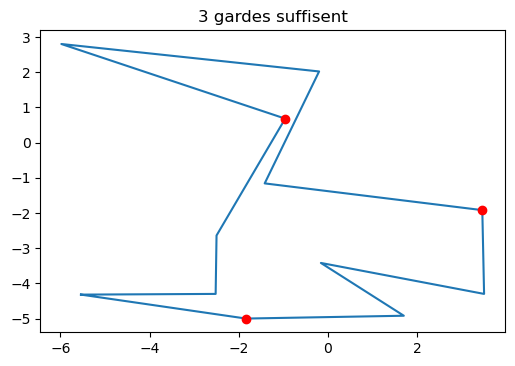

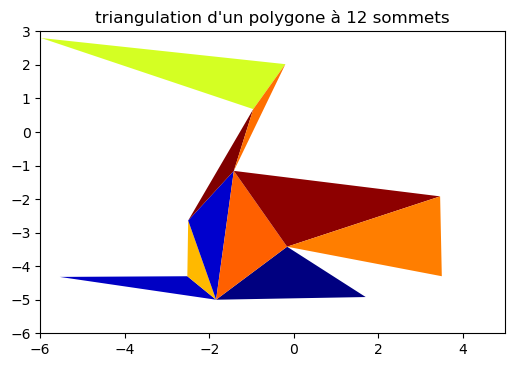

In [37]:

#polygone = [(0,5),(0,10),(16,10),(16,9),(13,9),(13,5),(15,5),(15,0),(12,0),(12,2),(14,2),(14,4),(10,4),(10,7),(9,7),(9,3),(5,3),(5,8),(2,8),(2,5)]
polygone = [[-5.54,-4.32],[-1.84,-5,44],[1.7,-4.92],[-0.16,-3.42],[3.5,-4.3],[3.46,-1.92],[-1.42,-1.16],[-0.2,2.02],[-5.98, 2.8],[-0.96,0.68],[-2.5,-2.64],[-2.52,-4.3]]
polygone = [(elem[0],elem[1]) for elem in polygone]

[liste_triangles,couleur] = res_gardes(polygone)
x = [elem[0] for elem in polygone]
y = [elem[1] for elem in polygone]
x.append(polygone[0][0])
y.append(polygone[0][1])
plot(x,y)

xr = [elem[0] for elem in couleur]
yr = [elem[1] for elem in couleur]
plot(xr,yr,'o',c = 'red')
title('3 gardes suffisent')

draw_liste_triangles(liste_triangles)
title("triangulation d'un polygone à 12 sommets")

axis([-6,5,-6,3])
rcParams['figure.dpi'] = 100


In [38]:
def equation_droite(P0,P1,M):
    """utile pour demi plan"""
    return (P1[0]-P0[0])*(M[1]-P0[1])-(P1[1]-P0[1])*(M[0]-P0[0])

def voisin_sommet(n,i,di):
    return (i+di)%n

def nouveau_polygone(polygone,i_debut,i_fin):
    """decoupe un polygone"""
    n = len(polygone)
    p = []
    i = i_debut
    while i!=i_fin:
        p.append(polygone[i])
        i = voisin_sommet(n,i,1)
    p.append(polygone[i_fin])
    return p 

def is_in_region1(A,B,M):
    """region pour le point C"""
    if ([M[0],M[1]]==[B[0],A[1]] or [M[0],M[1]]==[B[0],B[1]]):
        return False
    horh = (equation_droite(B,[B[0]+1,B[1]],M)) <= 0
    horb = (equation_droite(A,[B[0]+1,A[1]],M)) >= 0
    vert = (equation_droite(B,[B[0],A[1]],M)) >= 0
    
    return ((horb and vert) and horh)   

def is_in_region2(A,C,M):
    """region pour D """
    if ([M[0],M[1]]==[A[0],A[1]] or [M[0],M[1]]==[C[0],C[1]]):
        return False
    vertd = (equation_droite(C,[C[0],C[1]-1],M)) <= 0
    vertg = (equation_droite(A,[A[0],A[1]-1],M)) >= 0
    hor = (equation_droite(A,C,M)) <= 0
    return ((vertd and hor) and vertg)  

def is_in_region3(C,P,M):
    """region pour D subsidiaire"""
    if ([M[0],M[1]]==[C[0],C[1]] or [M[0],M[1]]==[P[0],P[1]]):
        return False
    horh = (equation_droite(C,[C[0]+1,C[1]],M)) <= 0
    horb = (equation_droite(P,[P[0]+1,P[1]],M)) >= 0
    vert = (equation_droite(C,[P[0],P[1]],M)) >= 0
    
    return ((horb and vert) and horh)   
   

In [39]:
def find_C(Polygone,nA,nB):
    'minx maxy et ne dois pas etre voisin de C'
    n = len(Polygone)
    A = Polygone[nA]
    B = Polygone[nB]
    liste_c = []
    for i in range(0,n):
        if (i == (nA+1)%n) or (i == (nA-1)%n):
            continue
        if is_in_region1(A,B,Polygone[i]):
            liste_c.append(i)
    max_i = liste_c[0]
    for i in liste_c:
        if (Polygone[i][0]<Polygone[max_i][0]) or ((Polygone[i][0]==Polygone[max_i][0])and Polygone[i][1]>Polygone[max_i][1]):
            max_i = i
    return(max_i)


def find_P(Polygone,C):
    """trouver le projeté de C sur la face sous C"""
    n = len(Polygone)
    minY = C[1]
    for i in range(0,n): 
        minY = min(minY,Polygone[i][1])
    
    maxY = minY
    for i in range(0,n):
        v = voisin_sommet(n,i,1)
        if (Polygone[i][1]<C[1]) and (Polygone[i][1]==Polygone[v][1]):
            if (((Polygone[i][0]<=C[0]) and (C[0]<=Polygone[v][0]))or ((Polygone[i][0]>=C[0]) and (C[0]>=Polygone[v][0]))):
                maxY = max(Polygone[i][1],maxY)       
    return([C[0],maxY])       
    
def find_D(Polygone,nA,nB,nC):
    '''highest then rightmost or leftmost then lowest '''
    n = len(Polygone)
    A = Polygone[nA]
    B = Polygone[nB]
    C = Polygone[nC]
    liste_d = []
    for i in range(0,len(Polygone)):
        if is_in_region2(A,C,Polygone[i]):
            liste_d.append(i)
    
    if not(liste_d == []):
        max_i = liste_d[0]
        for i in liste_d:
            if (Polygone[i][1]>Polygone[max_i][1]) or ((Polygone[i][1]==Polygone[max_i][1]) and Polygone[i][0]>Polygone[max_i][0]):
                max_i = i
        return(max_i)
    """d ne convient pas il faut aller chercher dans R3"""
    P = find_P(Polygone,C)
    '''minimum x then minimum y '''
    liste_d2 = []
    for i in range(0,len(Polygone)):
        if is_in_region3(C,P,Polygone[i]):
            liste_d2.append(i)
    max_i = liste_d2[0]
    for i in liste_d2:
        if (Polygone[i][0]<Polygone[max_i][0]) or ((Polygone[i][0]==Polygone[max_i][0])and Polygone[i][1]<Polygone[max_i][1]):
            max_i = i
    return(max_i)

In [40]:
"""operations de rotations et symetries pour pouvoir toujours se ramener au meme cas"""

def sym_x(Polygone):
    rendu = []
    for x,y in Polygone:
        rendu.append([x,-y])
    return rendu

def sym_y(Polygone):
    rendu = []
    for x,y in Polygone:
        rendu.append([-x,y])
    return rendu

def rot_90h(Polygone):
    rendu = []
    for x,y in Polygone:
        rendu.append([y,-x])
    return rendu

def realign(Polygone,edge):
    
    def est_dessus(Polygone,edge):
        '''compter le nombre de points au dessous du milieu pour savoir si on est au dessus ou en dessous'''
        milieu = [0.5*(Polygone[edge[0]][0]+Polygone[edge[0]][0]), 0.5*(Polygone[edge[0]][1]+Polygone[edge[0]][1])]
        n = len(Polygone)

        n_dessous = 0

        for i in range(0,n):
            v = voisin_sommet(n,i,1)
            if (Polygone[i][1]<milieu[1]) and (Polygone[i][1]==Polygone[v][1]):
                '''dessous'''
                if (((Polygone[i][0]<=milieu[0]) and (milieu[0]<=Polygone[v][0]))or ((Polygone[i][0]>=milieu[0]) and (milieu[0]>=Polygone[v][0]))):
                    n_dessous+=1
        return(n_dessous%2 == 0)
 
    """realigne le polygone pour avoir le bon sens avec le reste du pol en bas"""
    'edge <'
    n = len(Polygone)
    
    suivant = (edge[1]+1)%n if (edge[1]+1)%n != edge[0] else (edge[1]-1)%n
    precedent = (edge[0]-1)%n if (edge[0]-1)%n != edge[1] else (edge[0]+1)%n
    
    """cas vertical"""
    if (Polygone[edge[1]][0] == Polygone[suivant][0]) and (Polygone[edge[0]][0] == Polygone[precedent][0]):
        Polygone = rot_90h(Polygone)
    
    """cas angle droit"""
    if (Polygone[edge[1]][0] - Polygone[edge[0]][0])==0:
        
        if (Polygone[edge[1]][0] >= Polygone[suivant][0]) and (Polygone[edge[0]][0] >= Polygone[precedent][0]):
            return [sym_y(Polygone),-1]
        if (Polygone[edge[1]][0] <= Polygone[suivant][0]) and (Polygone[edge[0]][0] <= Polygone[precedent][0]):
            return [Polygone,1]
        else:
            '''attention a si le polygone est dessus ou dessous'''
            if est_dessus(Polygone,edge):
                Polygone = rot_90h(rot_90h(Polygone))
                
                
            if (Polygone[suivant][1] - Polygone[precedent][1])/(Polygone[suivant][0] - Polygone[precedent][0])<=0:
                return [sym_x(Polygone),-1]
            else:
                return [Polygone,1]

    """cas horizontal non angle droit"""
    if (Polygone[edge[1]][0] >= Polygone[suivant][0]) and (Polygone[edge[0]][0] >= Polygone[precedent][0]):
        if (Polygone[edge[1]][1] - Polygone[edge[0]][1])/(Polygone[edge[1]][0] - Polygone[edge[0]][0])<=0:
            return [sym_y(Polygone),-1]
        else:
            return [sym_y(sym_x(Polygone)),1]
    
    if (Polygone[edge[1]][0] <= Polygone[suivant][0]) and (Polygone[edge[0]][0] <= Polygone[precedent][0]):
        if (Polygone[edge[1]][1] - Polygone[edge[0]][1])/(Polygone[edge[1]][0] - Polygone[edge[0]][0])<=0:
            return [sym_x(Polygone),-1]
        else:
            return [Polygone,1]

    '''attention si le polygone est dessus ou dessous'''
    if est_dessus(Polygone,edge):
                Polygone = rot_90h(rot_90h(Polygone))
            
            
    if (Polygone[edge[1]][1] - Polygone[edge[0]][1])/(Polygone[edge[1]][0] - Polygone[edge[0]][0])<=0:
        return [sym_x(Polygone),-1]
    else:
        return [Polygone,1]


In [41]:
def rect(Polygone,edge, liste_rect):
    """decoupe de polygone de facon recursive en le gardant dans le bon sens"""
    n = len(Polygone)
    if n==4:
        liste_rect.append(Polygone)
    if n>4:
        Poly, sens = realign(Polygone,edge)
        if Poly[edge[0]][0]<=Poly[edge[1]][0]: # A en bas a gauche B en haut a droite
            nA = edge[0]
            nB = edge[1]
        else: 
            nA = edge[1]
            nB = edge[0]
        nC = find_C(Poly,nA,nB)
        nD = find_D(Poly,nA,nB,nC)
        quad = [Polygone[nA],Polygone[nB],Polygone[nC],Polygone[nD]]
        
        liste_rect.append(quad)
        
        if sens == 1:
            P1 = nouveau_polygone(Polygone,nC%n,nD%n) # probleme si le pol n'est pas dans le bon sens
            P2 = nouveau_polygone(Polygone,nB%n,nC%n)
            P3 = nouveau_polygone(Polygone,nD%n,nA%n)
            
            rect(P1,[0, len(P1)-1], liste_rect)
            rect(P2,[0, len(P2)-1], liste_rect)
            rect(P3,[0, len(P3)-1], liste_rect)
        else:
            P1 = nouveau_polygone(Polygone,nD%n,nC%n) # probleme si le pol n'est pas dans le bon sens
            P2 = nouveau_polygone(Polygone,nC%n,nB%n)
            P3 = nouveau_polygone(Polygone,nA%n,nD%n)

            rect(P1,[0, len(P1)-1], liste_rect)
            rect(P2,[0, len(P2)-1], liste_rect)
            rect(P3,[0, len(P3)-1], liste_rect)


In [42]:
def draw_liste_triangles(liste_triangles):
    fig,ax = subplots()
    patches = []
    for triangle in liste_triangles:
        patches.append(Polygon(triangle))
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=1.0)
    colors = 100*numpy.random.rand(len(patches))
    p.set_array(numpy.array(colors))
    ax.add_collection(p)
    axis([200,700,500,1200])
    #axis([0,16,0,10])

    
def couleur_va(graph,sommet,liste_couleur,couleur):
    """ check si le sommet peut accepter cette couleur """
    for i in range(len(graph)):
        if graph[sommet][i]==1 and liste_couleur[i]==couleur:
            return False
    return True

def coloration_rec_4(graph,liste_couleur,sommet):
    """ coloration recursive """
    
    if sommet==len(graph):
        return True
    
    for couleur in range(1,5):
        if couleur_va(graph,sommet,liste_couleur,couleur):
            liste_couleur[sommet] = couleur
            if coloration_rec_4(graph,liste_couleur,sommet+1):
                return True
            liste_couleur[sommet] = 0
            
def quadricolore(graph):
    """renvoie liste des sommet colorés"""
    liste_couleur = [0 for i in range(len(graph))]
    if not coloration_rec_4(graph,liste_couleur,0):
        return False
    return liste_couleur

                
def polygone_vers_graph4(polygone):
    dic_sommets = {}
    n = 0
    for sommet in polygone:
        dic_sommets[sommet] = n
        n+=1
        
    matrice_adjacence = [[0 for j in range(len(polygone))] for i in range(len(polygone))]
    
    rectangles = []
    rect(polygone,[1,0],rectangles)
    
    
    for x,y,z,h in rectangles:
        matrice_adjacence[dic_sommets[x]][dic_sommets[y]] = 1
        matrice_adjacence[dic_sommets[y]][dic_sommets[x]] = 1
        
        matrice_adjacence[dic_sommets[x]][dic_sommets[z]] = 1
        matrice_adjacence[dic_sommets[z]][dic_sommets[x]] = 1
        
        matrice_adjacence[dic_sommets[y]][dic_sommets[z]] = 1
        matrice_adjacence[dic_sommets[z]][dic_sommets[y]] = 1
        
        matrice_adjacence[dic_sommets[x]][dic_sommets[h]] = 1
        matrice_adjacence[dic_sommets[h]][dic_sommets[x]] = 1
        
        matrice_adjacence[dic_sommets[y]][dic_sommets[h]] = 1
        matrice_adjacence[dic_sommets[h]][dic_sommets[y]] = 1
        
        matrice_adjacence[dic_sommets[z]][dic_sommets[h]] = 1
        matrice_adjacence[dic_sommets[h]][dic_sommets[z]] = 1
    
    
    couleur = quadricolore(matrice_adjacence)
    rouge,vert,bleu,noir = [],[],[],[]
    
    for sommet in polygone:
        if couleur[dic_sommets[sommet]]==1:
            rouge.append(sommet)
        if couleur[dic_sommets[sommet]]==2:
            vert.append(sommet) 
        if couleur[dic_sommets[sommet]]==3:
            bleu.append(sommet)
        if couleur[dic_sommets[sommet]]==4:
            noir.append(sommet)
    return [rouge,vert,bleu,noir]

def res_gardes4(polygone):
    rectangles = []
    rect(polygone,[1,0],rectangles)
    rouge,vert,bleu,noir = polygone_vers_graph4(polygone) 

    longueur_min,lv,lb,ln = len(rouge),len(vert),len(bleu), len(noir)
    couleur_min = rouge
    if lv<longueur_min: couleur_min,longueur_min = vert,lv
    if lb<longueur_min: couleur_min,longueur_min = bleu,lb
    if ln<longueur_min: couleur_min,longueur_min = noir,ln
    
    print(longueur_min, "gardes sont suffisants")
    
    return([rectangles,couleur_min])

## Test utilisant la quadrangulation

5 gardes sont suffisants


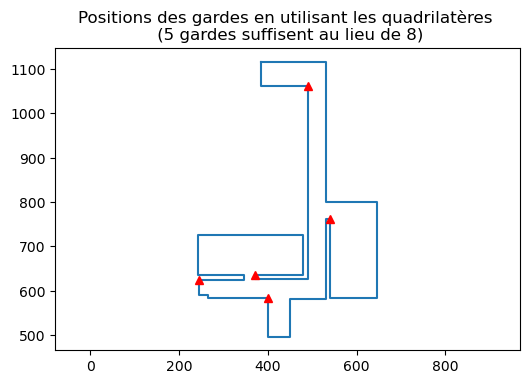

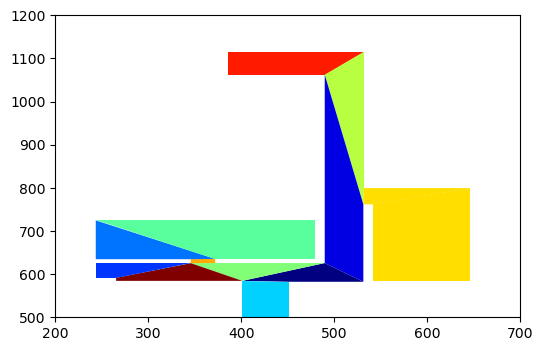

In [43]:
pol_l = [(0,5),(0,10),(16,10),(16,9),(13,9),(13,5),(15,5),(15,0),(12,0),(12,2),(14,2),(14,4),(10,4),(10,7),(9,7),(9,3),(5,3),(5,8),(2,8),(2,5)]
pol_l = [(385.5, 1115.3), (532.0, 1115.3), (532.0, 799.5), (646.3, 799.5), (646.3, 584.6), (541.3, 584.6), (541.3, 761.8), (531.3, 761.8), (531.3, 582.3), (451.2, 582.3), (451.2, 496.9), (401.2, 496.9), (401.2, 584.4), (265.5, 584.4), (265.5, 591.5), (244.1, 591.5), (244.1, 625.4), (345.8, 625.4), (345.8, 634.6), (243.6, 634.6), (243.6, 724.6), (479.2, 724.6), (479.2, 635.4), (372.0, 635.4), (372.0, 625.7), (489.8, 625.7), (489.8, 1062.3), (385.5, 1062.3)]



[rectangles,couleur] = res_gardes4(pol_l)
x = [elem[0] for elem in pol_l]
y = [elem[1] for elem in pol_l]
x.append(pol_l[0][0])
y.append(pol_l[0][1])
plot(x,y)
xr = [elem[0] for elem in couleur]
yr = [elem[1] for elem in couleur]
plot(xr,yr,'^',c = 'red')
axis('equal')
title('Positions des gardes en utilisant les quadrilatères \n (5 gardes suffisent au lieu de 8)')
#savefig('guardes2.png')

draw_liste_triangles(rectangles)
#savefig('rect2.png')
